# 以Restnet進行 CIFAR-10分類 

## 1. 資料載入及前處理

#### 使用torchvision 載入資料

In [1]:
from torch import  nn
# import torch as t
from torch.nn import  functional as F
import torch
import torchvision 
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage() # 把Tensor轉成Image，方便視覺化
import matplotlib.pyplot as plt
%matplotlib inline

torchvision数据集加载完后的输出是范围在[0, 1]之间的PILImage。我们将其标准化为范围在[-1, 1]之间的张量。

關於dataset與dataloader:
- 未來自行準備資料集時，由於各資料整理出的格式可能不同，需要繼承dataset的class類別自行定義修改、使資料output符合dataloader 格式    

### TRANSFORMS　資料轉換　　
在 torchvision 裏頭，有個API TORCHVISION.TRANSFORMS ，這個 API 中包含resize、crop 等常見的 data augmentation 操作，基本上 PyTorch 中的 data augmentation 操作都可以透過該API來實現  

以下操作：將資料轉換成tensor的資料型態，最後做narmalize　

In [2]:
# 定義對資料的預處理 
# image=(image-mean)/std

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
transform = transforms.Compose(
    [transforms.ToTensor(),             # 轉為Tensor
     transforms.Normalize(mean,std)])   # 轉為常態分佈標準化

In [3]:
import torch.utils.data as data

# 切分訓練與驗證資料集  
 # Random split
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


# 參數設定
batch_size = 100     # 每批次載入多少樣本
num_workers = 10     # 設定cpu使用多少處理執行緒來載入資料，0代表不使用
torch.manual_seed(0) # 固定亂數種子

# 切分訓練與驗證資料集
p_split = 0.8        # 設定訓練與驗證資料切分比例
train_set_size  = int(len(train_set) * p_split)
valid_set_size  = len(train_set)- train_set_size 

train_set, valid_set = data.random_split(train_set, [train_set_size, valid_set_size])  # random_split


# 利用 torch.utils.data.DataLoader 數據加載器，將打包好的數據可以迭代進模型中訓練
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, 
                                          num_workers=num_workers, pin_memory=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=100, shuffle=True, 
                                          num_workers=num_workers, pin_memory=True, drop_last=True)


# 測試資料集
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                                        pin_memory=True, drop_last=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 檢視資料大小
print('='*30)
print('Train data set:', len(train_set))
print('Valid data set:', len(valid_set))
print('Test data set:', len(test_set),'\n')


# 檢視資料數據加載器資料形狀，每筆迭代出來的數量即送入的batch_size大小
images,labels=next(iter(train_loader))
print('Train data set:', images.shape, labels.shape, len(train_loader))       # (batch_size,channel, h, w))

images,labels=next(iter(valid_loader))
print('Valid data set:', images.shape, labels.shape, len(valid_loader))

Files already downloaded and verified
Files already downloaded and verified
Train data set: 40000
Valid data set: 10000
Test data set: 10000 

Train data set: torch.Size([100, 3, 32, 32]) torch.Size([100]) 400
Valid data set: torch.Size([100, 3, 32, 32]) torch.Size([100]) 100


In [4]:
# (data, label) = trainset[100]
# print(classes[label])

# # 因為 train_loader 中的資料已經是normalize過的，所以在畫出來前要先 denormalize。
# # ((data+1)/2) 是為了還原被標準化的資料 
# show((data+1)/2).resize((100,100))


#### 視覺化呈現資料

In [5]:
# import matplotlib.pyplot as plt
# import numpy as np

# # 输出图像的函数
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()


# # 随机获取训练图片
# dataiter = iter(trainloader)
# images, labels = dataiter.next()

# # 显示图片
# imshow(torchvision.utils.make_grid(images))
# # 打印图片标签
# print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

## 2. 定義神經網路(CNN)
将之前神经网络章节定义的神经网络拿过来，并将其修改成输入为3通道图像(替代原来定义的单通道图像）。

- 預設的Restnet網路無法跑GPU平行運算
- 如何讓Restnet在GPU上平行運算?


In [6]:
from torchvision import models
model = models.resnet18(num_classes=10)

#  利用model summary 的 function 印出建構的 model 看看
from torchsummary import summary
summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

### 將模型移至GPU
* 先將模型指定至GPU，之後在執行訓練時也須配合將資料放入同一GPU 
* 最好明確指定GPU位置

In [7]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Assuming that we are on a CUDA machine, this should print a CUDA device:

# print(device)
# model.to(device)

In [8]:
# torch.cuda.set_device(0)  # 設定要將cuda放置到哪一片gpu
model.cuda()          # 注意，對module 而言 .cuda()不是inplace操作，需要變數去承接
torch.cuda.current_device() # 檢查目cuda前所在的gpu

0

## 运行模型
檢視输入和输出张量的大小

In [9]:
#  for _, data in enumerate(trainloader, 0):
#     input = data.to(device)
#     output = model(input)
#     print("Outside: input size", input.size(),
#           "output_size", output.size())

## 3. 定義損失函數和最佳化器(Loss 、Optimizer)
使用多分类的交叉熵损失函数和随机梯度下降优化器(使用momentum）

關於learnibg rate 參數設定
- lr 在空的模型中來講算是上限，如果是使用別人以預先訓練好的可以選擇更小的lr值
- 可手動加入 adaptive lr 讓lr 在訓練過程後段變小、加速模型收斂。(但optimizer已經是設定adam了，理論上應該是變動式?)
- lr一開始設太大可能會衝過頭(超過區域/全域最小值的谷底)無法收斂

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # 交叉熵
optimizer = optim.RMSprop(model.parameters(), lr= 1e-3)
optimizer

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 0
)

## 4. 訓練模型
重複執行以下流程：
- 輸入資料
- 正向傳播+反向傳播
- 更新參數

#### 加入進度條

In [11]:
train_Loss_list = []
valid_Loss_list = []

n_epoch = 50

for epoch in range(1, n_epoch + 1):  # loop over the dataset multiple times  

    train_loss = 0.0
    valid_loss = 0.0
    print('\nEpoch : ', epoch)

    ###################
    # train the model #
    ###################
    model.train()  # 明確指定model在訓練狀態(預設值)
    for i, data in enumerate(train_loader, 1): # i從1開始計數 
        
        # get the inputs 輸入資料
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda() # 把資料送入GPU(非inplace)
        #inputs, labels = inputs.to(device), labels.to(device) # 把資料送入GPU，注意使用.to() 需要指定引數
        
        # clear the gradients of all optimized variables 梯度清空為0
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(inputs)
        # calculate the batch loss
        loss = criterion(outputs, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # 更新參數
        optimizer.step()
        # update training loss
        train_loss += loss.item()  #如果是仅包含一个元素的tensor，可以使用.item()来得到对应的python数值
        
        # print statistics
        n = len(train_loader)  #  len(train_loader)=遍歷一個epoch的次數
        if i % n+1 == n :    # print every n mini-batches
            print('[epoch: %2d, i: %3d] train_loss: %.3f' % (epoch , i + 1 , train_loss / n))
            train_Loss_list.append(train_loss / n )
            train_loss = 0.0 # 每n回　loss 歸零重計


    ######################    
    # validate the model #
    ######################
    model.eval() # 啟動評估模式
    for i, data in enumerate(valid_loader, 1): # i從1開始計數 
        
        # get the inputs 輸入資料
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda() # 把資料送入GPU(非inplace)

        # zero the parameter gradients 梯度清空為0
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(inputs)
        # calculate the batch loss
        loss = criterion(outputs, labels)
        # update training loss
        valid_loss += loss.item()

        # print statistics
        n = len(valid_loader)   #  len(valid_loader)=遍歷一個epoch的次數
        if i % n+1 == n :    # print every n mini-batches
            print('[epoch: %2d, i: %3d] valid_loss: %.3f' % (epoch , i + 1 , valid_loss / n))
            valid_Loss_list.append(valid_loss / n )
            valid_loss = 0.0 # 每n回　loss 歸零重計

print('Finished Training')



Epoch :  1
[epoch:  1, i: 400] train_loss: 1.556
[epoch:  1, i: 100] valid_loss: 1.318

Epoch :  2
[epoch:  2, i: 400] train_loss: 1.066
[epoch:  2, i: 100] valid_loss: 1.087

Epoch :  3
[epoch:  3, i: 400] train_loss: 0.865
[epoch:  3, i: 100] valid_loss: 0.922

Epoch :  4
[epoch:  4, i: 400] train_loss: 0.715
[epoch:  4, i: 100] valid_loss: 0.922

Epoch :  5
[epoch:  5, i: 400] train_loss: 0.594
[epoch:  5, i: 100] valid_loss: 0.860

Epoch :  6
[epoch:  6, i: 400] train_loss: 0.485
[epoch:  6, i: 100] valid_loss: 0.879

Epoch :  7
[epoch:  7, i: 400] train_loss: 0.384
[epoch:  7, i: 100] valid_loss: 0.841

Epoch :  8
[epoch:  8, i: 400] train_loss: 0.310
[epoch:  8, i: 100] valid_loss: 0.904

Epoch :  9
[epoch:  9, i: 400] train_loss: 0.251
[epoch:  9, i: 100] valid_loss: 0.982

Epoch :  10
[epoch: 10, i: 400] train_loss: 0.201
[epoch: 10, i: 100] valid_loss: 1.059

Epoch :  11
[epoch: 11, i: 400] train_loss: 0.166
[epoch: 11, i: 100] valid_loss: 1.120

Epoch :  12
[epoch: 12, i: 40

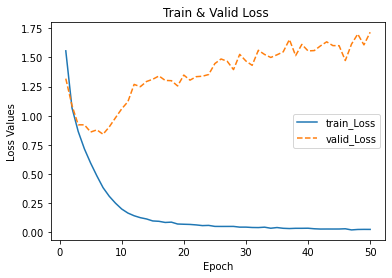

In [12]:
# 作圖
train_Loss, valid_Loss = train_Loss_list, valid_Loss_list
x = range(1, n_epoch+1 )
plt.plot(x, train_Loss, label='train_Loss')
plt.plot(x, valid_Loss, linestyle='--' ,label='valid_Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Values')
plt.title('Train & Valid Loss ')
plt.legend()
plt.show()

儲存訓練完的模型


In [13]:
PATH = './cifar_restnet18.pth'
torch.save(model.state_dict(), PATH)

### 報錯
ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])<br>
原因 ：
>The error is most likely thrown during training and if the current batch only contains a single sample. 
 模型中用了batchnomolization，訓練中用batch訓練的時候當前batch恰好只含一個sample，而由於BatchNorm操作需要多於一個數據計算平均值，因此造成該錯誤<br>

對策：
1. 從dataset中删掉一個sample。
2. 在torch.utils.data.DataLoader類中或自己創建的繼承於DataLoader的類中設置參數drop_last=True，把不夠一個batch_size的數據丟棄
3. trainloader = torch.utils.data.DataLoader(trainset, batch_size=6, shuffle=True, num_workers=2) 中把batch_size設為3的倍數

<br>
參考資料：<br>
https://www.cnblogs.com/zmbreathing/p/pyTorch_BN_error.html<br
https://discuss.pytorch.org/t/error-expected-more-than-1-value-per-channel-when-training/262 


## 5. 使用測試數據驗證結果

通过预测神经网络输出的标签来检查这个问题，并和正确样本进行(ground-truth）对比。如果预测是正确的，我们将样本添加到正确预测的列表中。

ok，第一步。让我们展示测试集中的图像来熟悉一下

In [32]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 输出图片
(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog


載入保存的模型

In [14]:
restnet18 = models.resnet18(num_classes=10)
restnet18.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [30]:
outputs = restnet18(images)
outputs.shape

torch.Size([128, 10])

#### 檢視模型判定的結果

输出是10个类别的量值。一个类的值越高，网络就越认为这个图像属于这个特定的类。让我们得到最高量值的下标/索引；

In [35]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(8)))

Predicted:    dog  ship  ship plane  deer  frog   car  frog


神經網路在整個數據集上的表現

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data

        
        # 計算圖片在每個類別上的分數
        outputs = restnet18(images)
        # 得分最高的那個類別
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 74 %


比随机选取(即从10个类中随机选择一个类，正确率是10%）要好很多。看来网络确实学到了一些东西。

那么哪些是表现好的类呢？哪些是表现的差的类呢？

In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = restnet18(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 75 %
Accuracy of   car : 85 %
Accuracy of  bird : 69 %
Accuracy of   cat : 52 %
Accuracy of  deer : 70 %
Accuracy of   dog : 71 %
Accuracy of  frog : 75 %
Accuracy of horse : 79 %
Accuracy of  ship : 96 %
Accuracy of truck : 82 %


## PyTorch繪製訓練過程中Accuracy和loss的學習曲線

參考資料：  
[PyTorch绘制训练过程的accuracy和loss曲线](https://blog.csdn.net/tequilaro/article/details/81841748)



In [38]:
restnet18 = models.resnet18(num_classes=10)
restnet18.load_state_dict(torch.load(PATH))
restnet18??

Signature:       restnet18(*input, **kwargs)
Type:            ResNet
String form:    
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, mo

In [36]:
#定义两个数组
Loss_list = []
Accuracy_list = []

Loss_list.append(train_loss / (len(train_dataset)))
Accuracy_list.append(100 * train_acc / (len(train_dataset)))

#我这里迭代了200次，所以x的取值范围为(0，200)，然后再将每次相对应的准确率以及损失率附在x上
x1 = range(0, 200)
x2 = range(0, 200)
y1 = Accuracy_list
y2 = Loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Test accuracy vs. epoches')
plt.ylabel('Test accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Test loss vs. epoches')
plt.ylabel('Test loss')
plt.show()
plt.savefig("accuracy_loss.jpg")

NameError: name 'train_loss' is not defined